In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#for adding heavy chain
complementator = str.maketrans("ACGT", "TGCA") 

In [4]:
# for making plots:
sbs12_ordered = ["C>A", "G>T", "C>G", "G>C", "C>T", "G>A", "T>A", "A>T", "T>C", "A>G", "T>G", "A>C"]
color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}

In [5]:
def histogram_intersection(hist1: np.ndarray, hist2: np.ndarray):
    return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)

In [6]:
def df_intersection(lst_of_ndarray, df_sort_by_G4_id):
    lst = []
    for i in range(len(lst_of_ndarray)):
        
        j = 0

        while j < len(lst_of_ndarray):
            row = []
            if len(lst_of_ndarray[i]) > len(lst_of_ndarray[j]):
                length = len(lst_of_ndarray[j])

                row.append(i)
                row.append(j)
                row.append(histogram_intersection(lst_of_ndarray[i][:length], lst_of_ndarray[j]))
                lst.append(row)
            elif len(lst_of_ndarray[i]) < len(lst_of_ndarray[j]):
                length = len(lst_of_ndarray[i])

                row.append(i)
                row.append(j)
                row.append(histogram_intersection(lst_of_ndarray[i], lst_of_ndarray[j][:length]))
                lst.append(row)
            else:
                row.append(i)
                row.append(j)
                row.append(histogram_intersection(lst_of_ndarray[i], lst_of_ndarray[j]))
            
                lst.append(row)
            j += 1
    
    df = pd.DataFrame(lst, columns=['G4_id_1', 'G4_id_2', 'intersection'])
    df['G4_id_1'] = np.repeat(df_sort_by_G4_id['G4_id'].unique(), len(lst_of_ndarray)).tolist()
    df['G4_id_2'] = df_sort_by_G4_id['G4_id'].unique().tolist()*len(lst_of_ndarray)
    
    return df

In [7]:
def get_intersection_df(df, up_side=True, i_col=None):
    if up_side==True:
        df_sort_up = df[(df['side'] == 'up')][['G4_id', 'number_of_win', i_col]] \
            .sort_values(by=['G4_id','number_of_win'])
    
        bins_up = []
        for G4_id in df_sort_up['G4_id'].unique():
            bins_up.append(df_sort_up[(df_sort_up['G4_id'] == G4_id)][i_col].values)

        df_out = df_intersection(bins_up, df_sort_up)
    
    else:
        df_sort_down = df[(df['side'] == 'down')][['G4_id', 'number_of_win', i_col]] \
            .sort_values(by=['G4_id','number_of_win'])

        bins_down = []
        for G4_id in df_sort_down['G4_id'].unique():
            bins_down.append(df_sort_down[(df_sort_down['G4_id'] == G4_id)][i_col].values)

        df_out = df_intersection(bins_down, df_sort_down)
    
    return df_out


def plot_intersecton(df: pd.DataFrame, title=None):
    output_plot = sns.clustermap(df.pivot(index='G4_id_1', columns='G4_id_2', values='intersection'), figsize=(12, 12),
           xticklabels=True, yticklabels=True).fig.suptitle(title)

    

In [8]:
def get_norm_mutspec(df):
    
    normMut = pd.DataFrame()
    
    normMut[['A>C','A>G','A>T']] = df[['A>C','A>G','A>T']].div(df['A'], axis=0)
    normMut[['C>A','C>G','C>T']] = df[['C>A','C>G','C>T']].div(df['C'], axis=0)
    normMut[['G>A', 'G>C', 'G>T']] = df[['G>A', 'G>C', 'G>T']].div(df['G'], axis=0)
    normMut[['T>A', 'T>C', 'T>G']] = df[['T>A', 'T>C', 'T>G']].div(df['T'], axis=0)
    
    normMut = normMut.fillna(0)
    normMut = normMut.div(normMut.sum(axis=1), axis=0)
    
    normMut.columns = normMut.columns.str.translate(complementator)
    
    return normMut

# HGT win analysis:

In [9]:
df_win_hgt = pd.read_csv('../data/processed/df_win_hgt.csv')

In [10]:
df_win_hgt

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,up,91,185,194,GCGAACATAC,4.0,3.0,2.0,1.0,...,34.0,24.0,84.0,692.0,24.0,25.0,8.0,79.0,19.0,1692.0
1,1,up,90,186,195,CGAACATACT,4.0,3.0,1.0,2.0,...,34.0,0.0,74.0,132.0,0.0,4.0,6.0,68.0,0.0,505.0
2,1,up,89,187,196,GAACATACTT,4.0,2.0,1.0,3.0,...,0.0,0.0,1.0,132.0,0.0,4.0,4.0,0.0,0.0,290.0
3,1,up,88,188,197,AACATACTTA,5.0,2.0,0.0,3.0,...,0.0,0.0,1.0,132.0,0.0,0.0,4.0,0.0,0.0,286.0
4,1,up,87,189,198,ACATACTTAC,4.0,3.0,0.0,3.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9507,74,down,87,77,86,ACGCGATAGC,3.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9508,74,down,88,78,87,CGCGATAGCA,3.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9509,74,down,89,79,88,GCGATAGCAT,3.0,2.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9510,74,down,90,80,89,CGATAGCATT,3.0,2.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Text(0.5, 1.0, 'Number of mutation around G4 in HGT')]

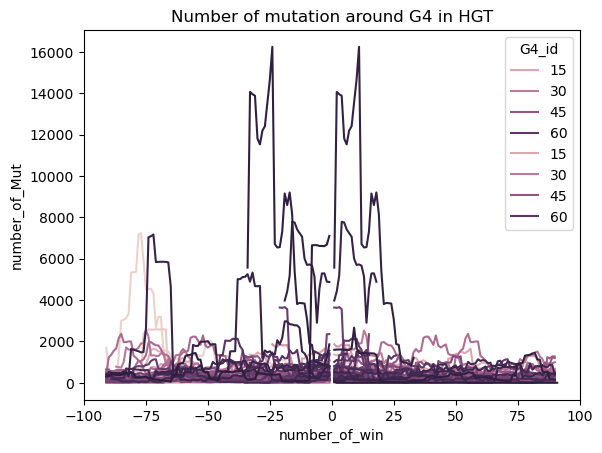

In [11]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_hgt[df_win_hgt['side']=='up'], x=-df_win_hgt['number_of_win'], y='number_of_Mut', hue='G4_id')
sns.lineplot(data=df_win_hgt[df_win_hgt['side']=='down'], x='number_of_win', y='number_of_Mut', hue='G4_id')\
    .set(title='Number of mutation around G4 in HGT')

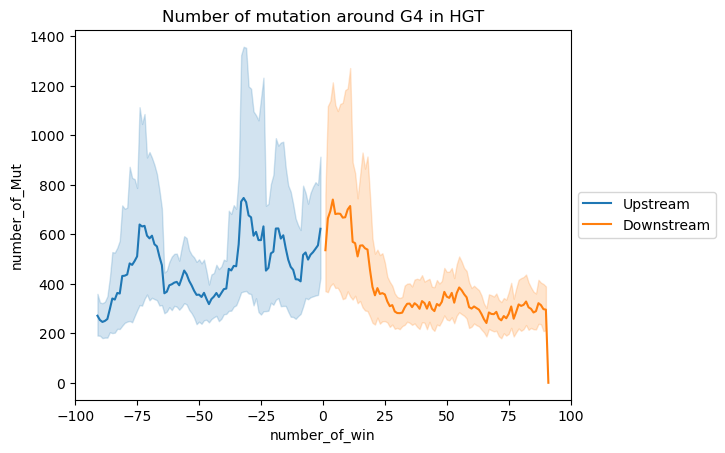

In [12]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_hgt[df_win_hgt['side']=='up'], 
             x=-df_win_hgt['number_of_win'], y='number_of_Mut', label='Upstream')
sns.lineplot(data=df_win_hgt[df_win_hgt['side']=='down'], 
             x='number_of_win', y='number_of_Mut', label='Downstream')
axs.set(title='Number of mutation around G4 in HGT')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [13]:
df_i_up_hgt = get_intersection_df(df_win_hgt, up_side=True, i_col='number_of_Mut')
df_i_down_hgt = get_intersection_df(df_win_hgt, up_side=False, i_col='number_of_Mut')

C:\Users\777\AppData\Local\Temp\ipykernel_11356\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)
C:\Users\777\AppData\Local\Temp\ipykernel_11356\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)


[Text(0.5, 1.0, 'Downstream')]

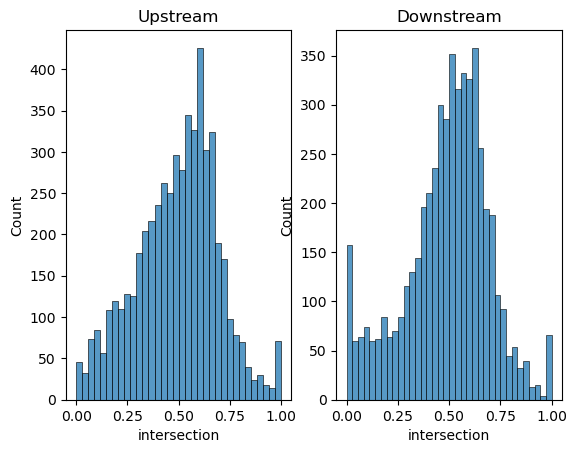

In [14]:
fig, axs = plt.subplots(ncols=2)
sns.histplot(df_i_up_hgt['intersection'], ax=axs[0]).set(title='Upstream')
sns.histplot(df_i_down_hgt['intersection'], ax=axs[1]).set(title='Downstream')

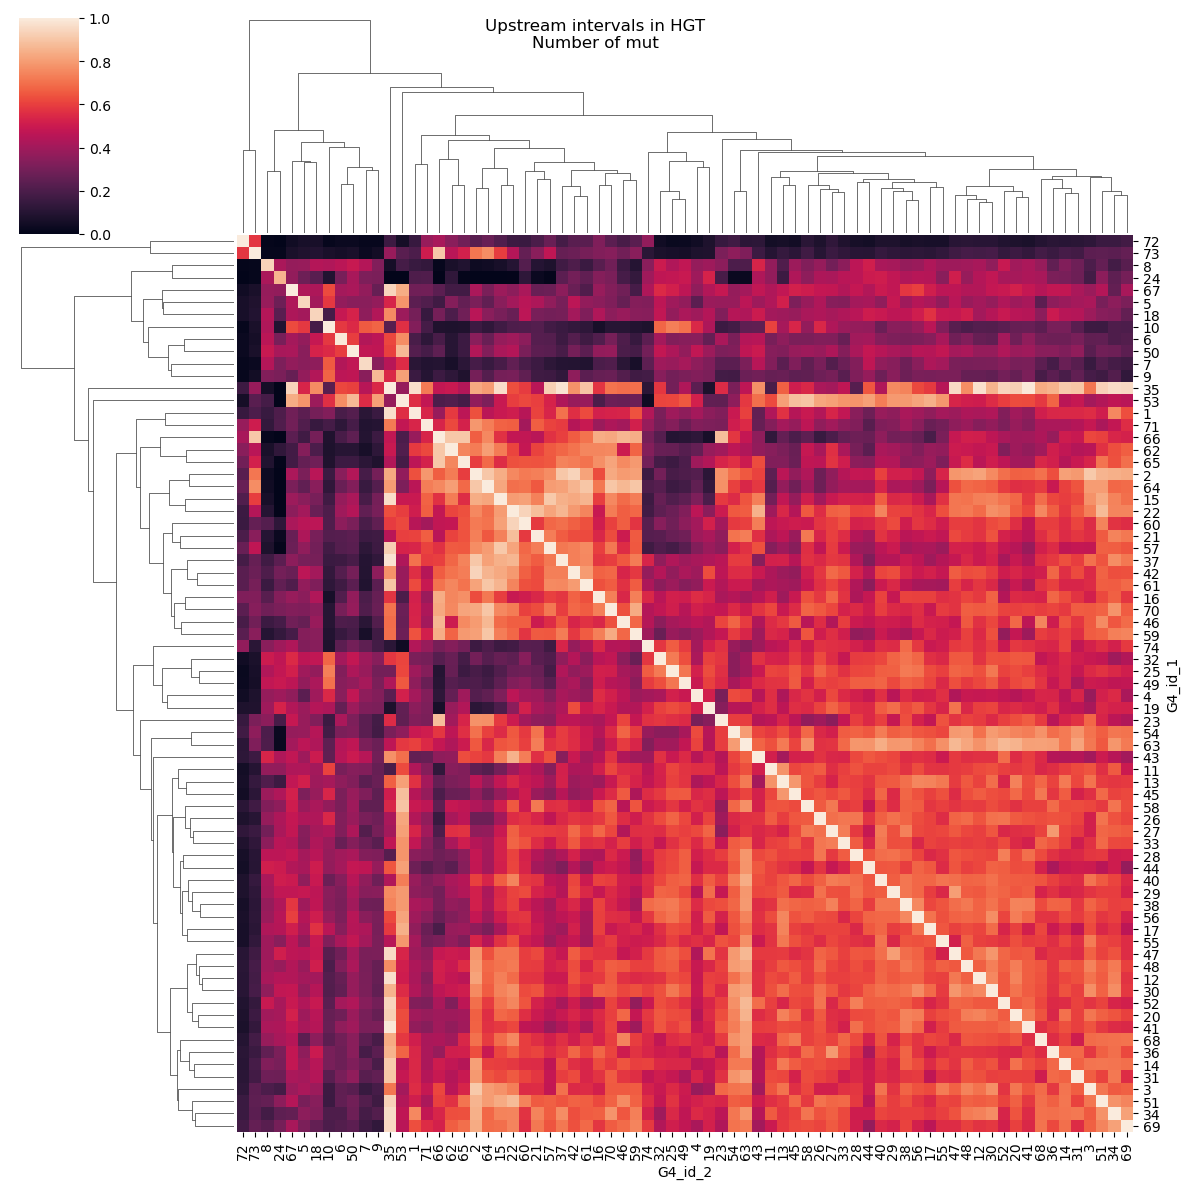

In [15]:
plot_intersecton(df_i_up_hgt, title='Upstream intervals in HGT\nNumber of mut')

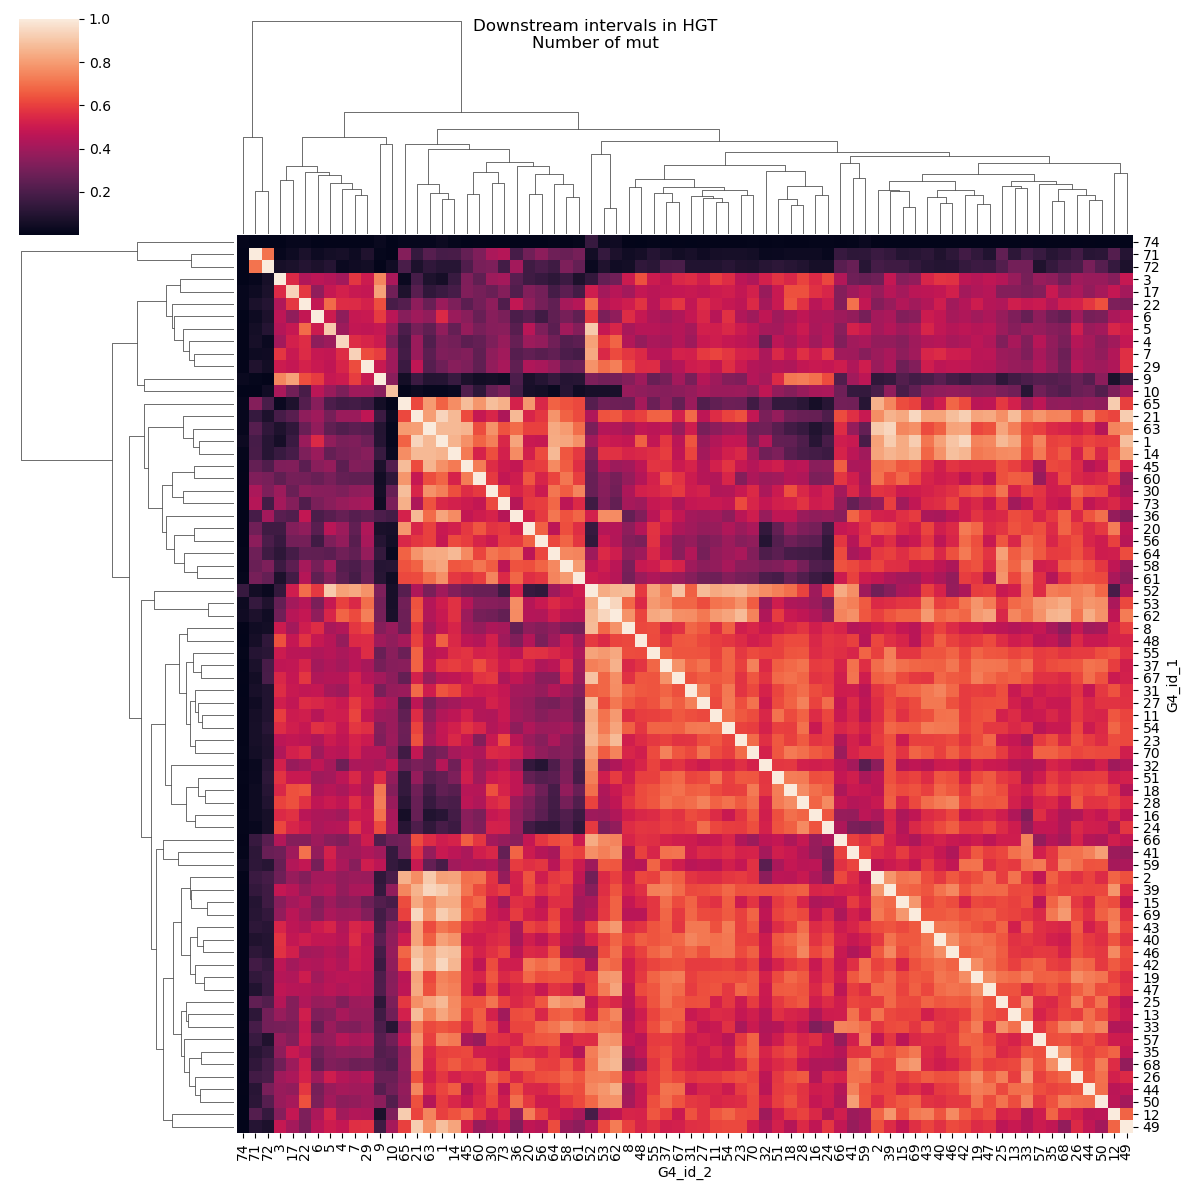

In [16]:
plot_intersecton(df_i_down_hgt, title='Downstream intervals in HGT\nNumber of mut')

### We have outgroups: ???
- upstream: 72, 73, 8, 24, 67, 5, 18, 10, 6, 50, 7, 9
- downstream: 74, 71, 72, 3, 17, 22, 6, 5, 4, 7, 29, 9, 10

In [17]:
outgroup_up_hgt = [72, 73, 8, 24, 67, 5, 18, 10, 6, 50, 7, 9]
outgroup_down_hgt = [74, 71, 72, 3, 17, 22, 6, 5, 4, 7, 29, 9, 10]

In [18]:
df_win_hgt[(df_win_hgt['G4_id'].isin(outgroup_up_hgt)) & (df_win_hgt['side'] == 'up')]

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
220,5,up,91,854,863,TAAGCTATAC,4.0,2.0,1.0,3.0,...,0.0,0.0,4.0,54.0,0.0,0.0,0.0,8.0,0.0,122.0
221,5,up,90,855,864,AAGCTATACT,4.0,2.0,1.0,3.0,...,0.0,0.0,4.0,54.0,0.0,0.0,0.0,8.0,0.0,122.0
222,5,up,89,856,865,AGCTATACTA,4.0,2.0,1.0,3.0,...,0.0,0.0,4.0,54.0,0.0,0.0,0.0,8.0,0.0,122.0
223,5,up,88,857,866,GCTATACTAA,4.0,2.0,1.0,3.0,...,0.0,0.0,4.0,38.0,0.0,0.0,0.0,8.0,0.0,88.0
224,5,up,87,858,867,CTATACTAAC,4.0,3.0,0.0,3.0,...,0.0,0.0,40.0,30.0,0.0,0.0,0.0,44.0,0.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4696,73,up,5,16330,16339,TACATAGCAC,4.0,3.0,1.0,2.0,...,26.0,4.0,44.0,382.0,6.0,0.0,24.0,46.0,0.0,976.0
4697,73,up,4,16331,16340,ACATAGCACA,5.0,3.0,1.0,1.0,...,26.0,4.0,18.0,382.0,6.0,0.0,14.0,16.0,0.0,906.0
4698,73,up,3,16332,16341,CATAGCACAT,4.0,3.0,1.0,2.0,...,22.0,4.0,18.0,350.0,6.0,0.0,14.0,16.0,0.0,832.0
4699,73,up,2,16333,16342,ATAGCACATT,4.0,2.0,1.0,3.0,...,16.0,8.0,192.0,350.0,10.0,0.0,20.0,220.0,0.0,1218.0


In [19]:
df_win_hgt['number_of_Mut'].mean()

437.2586206896552

In [20]:
df_win_hgt['number_of_Mut'].median()

236.0

In [21]:
df_win_hgt[(df_win_hgt['G4_id'].isin(outgroup_up_hgt)) & (df_win_hgt['side'] == 'up')]['number_of_Mut'].median()

61.0

In [22]:
df_win_hgt[((df_win_hgt['G4_id'] == 72) | (df_win_hgt['G4_id'] == 73)) & (df_win_hgt['side'] == 'up')]['number_of_Mut'].median()

5660.0

In [23]:
df_win_hgt[((df_win_hgt['G4_id'] == 74) | (df_win_hgt['G4_id'] == 71) | (df_win_hgt['G4_id'] == 72)) & (df_win_hgt['side'] == 'down')]['number_of_Mut'].median()

0.0

In [24]:
df_win_hgt[((df_win_hgt['G4_id'] == 71) | (df_win_hgt['G4_id'] == 72)) & (df_win_hgt['side'] == 'down')]['number_of_Mut'].median()

5696.0

In [25]:
df_win_hgt[(df_win_hgt['G4_id'] == 74) & (df_win_hgt['side'] == 'down') & (df_win_hgt['number_of_Mut'] > 0)]

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
9421,74,down,1,16560,16569,CATCACGATG,3.0,3.0,2.0,2.0,...,7.0,2.0,6.0,11.0,2.0,0.0,4.0,5.0,0.0,58.0


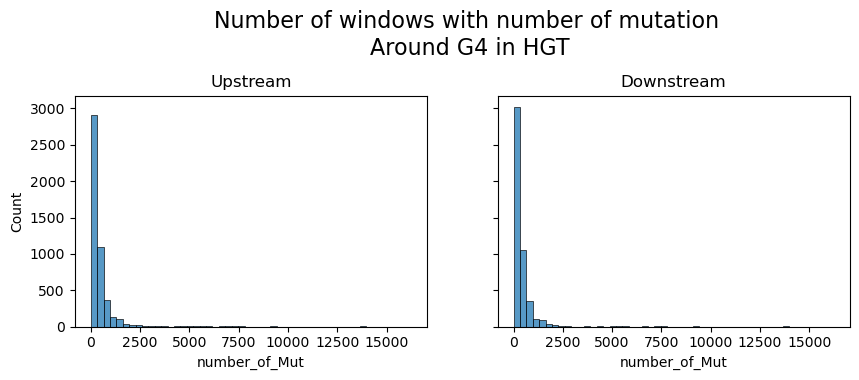

In [26]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))
sns.histplot(df_win_hgt[df_win_hgt['side'] == 'up']['number_of_Mut'], ax=axs[0], bins=50).set(title='Upstream')
sns.histplot(df_win_hgt[df_win_hgt['side'] == 'down']['number_of_Mut'], ax=axs[1], bins=50).set(title='Downstream')

fig.suptitle(x=0.52, y=1, t='Number of windows with number of mutation \nAround G4 in HGT', fontsize=16, ha='center', va='bottom')

fig.subplots_adjust(top=0.88)


Text(0.5, 1, 'Number of windows with number of mutation <= 2500\nAround G4 in HGT')

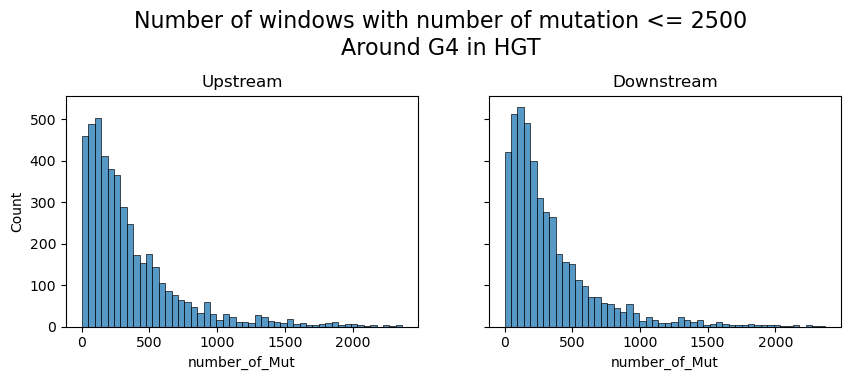

In [27]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))
sns.histplot(df_win_hgt[(df_win_hgt['side'] == 'up') & (df_win_hgt['number_of_Mut'] <= 2500) & (df_win_hgt['number_of_Mut'] > 0)]['number_of_Mut'], ax=axs[0], bins=50).set(title='Upstream')
sns.histplot(df_win_hgt[(df_win_hgt['side'] == 'down') & (df_win_hgt['number_of_Mut'] <= 2500) & (df_win_hgt['number_of_Mut'] > 0)]['number_of_Mut'], ax=axs[1], bins=50).set(title='Downstream')

fig.suptitle(x=0.5, y=1, t='Number of windows with number of mutation <= 2500\nAround G4 in HGT', fontsize=16, ha='center', va='bottom')

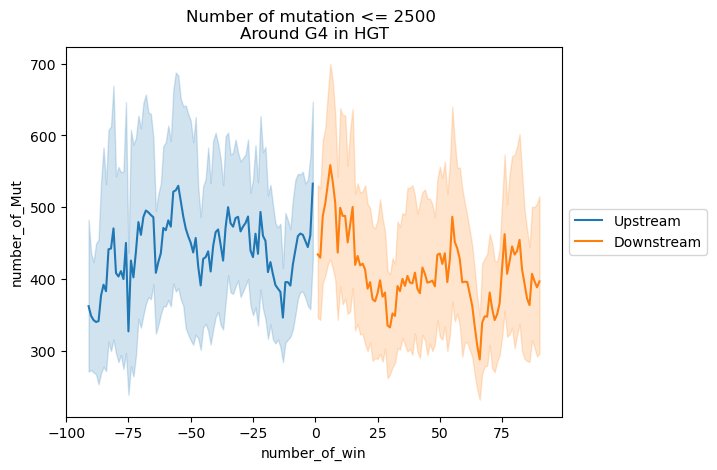

In [28]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_hgt[(df_win_hgt['side'] == 'up') & (df_win_hgt['number_of_Mut'] <= 2500) & (df_win_hgt['number_of_Mut'] > 100)],
             x=-df_win_hgt['number_of_win'], y='number_of_Mut', label='Upstream')
sns.lineplot(data=df_win_hgt[(df_win_hgt['side'] == 'down') & (df_win_hgt['number_of_Mut'] <= 2500) & (df_win_hgt['number_of_Mut'] > 100)], 
             x='number_of_win', y='number_of_Mut', label='Downstream')
axs.set(title='Number of mutation <= 2500 \nAround G4 in HGT')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

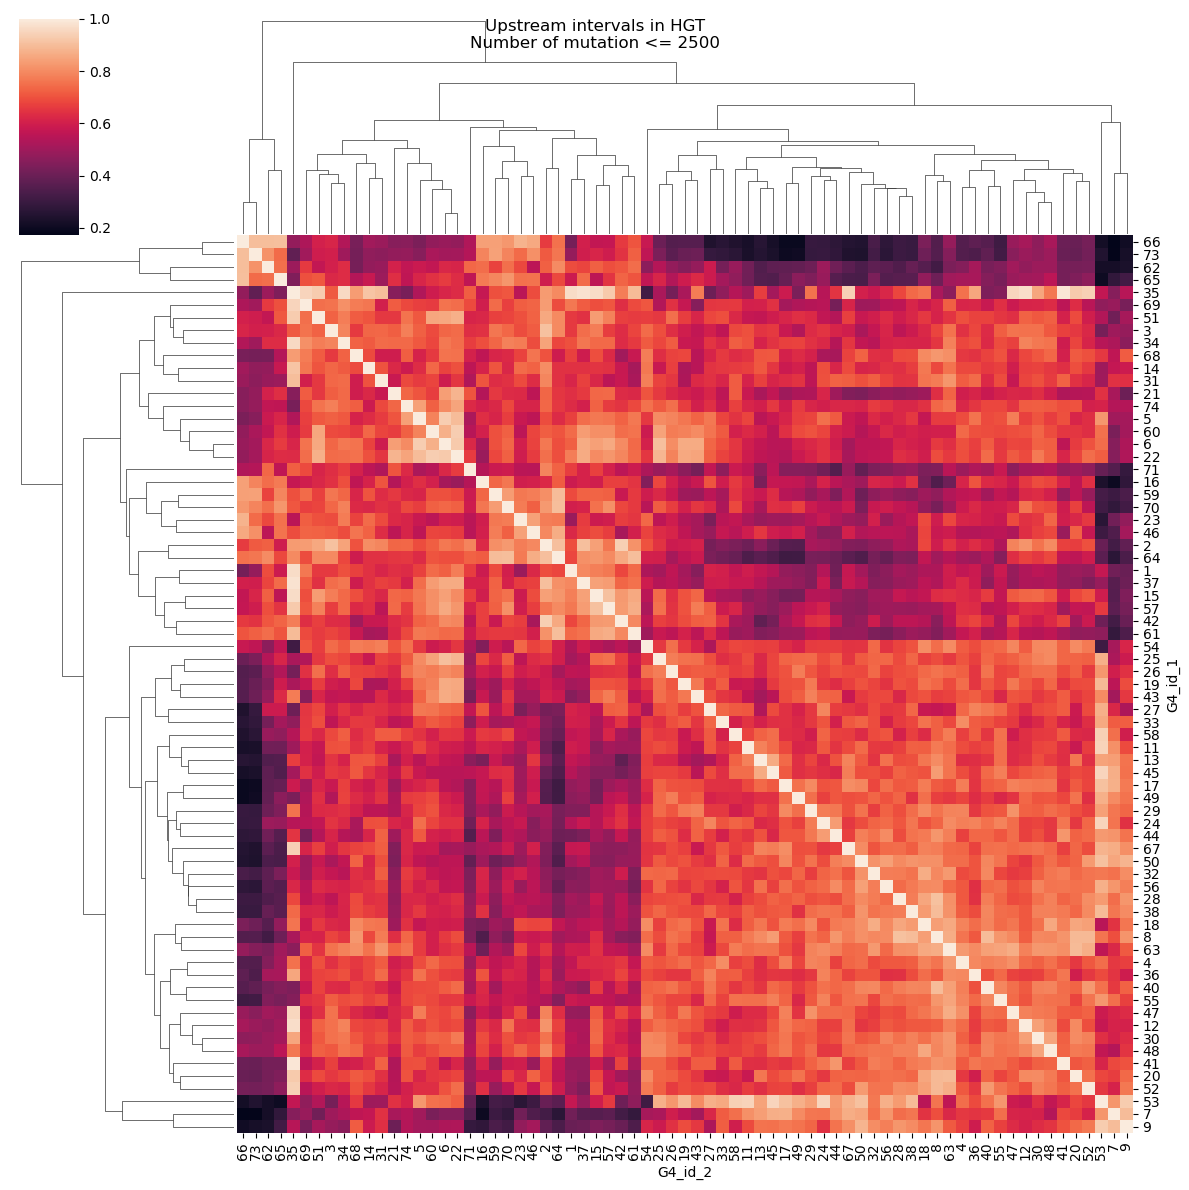

In [29]:
plot_intersecton(get_intersection_df
                 (df_win_hgt[(df_win_hgt['number_of_Mut'] <= 2500) & (df_win_hgt['number_of_Mut'] > 100)], 
                 up_side=True, i_col='number_of_Mut'),
                title='Upstream intervals in HGT\nNumber of mutation <= 2500')

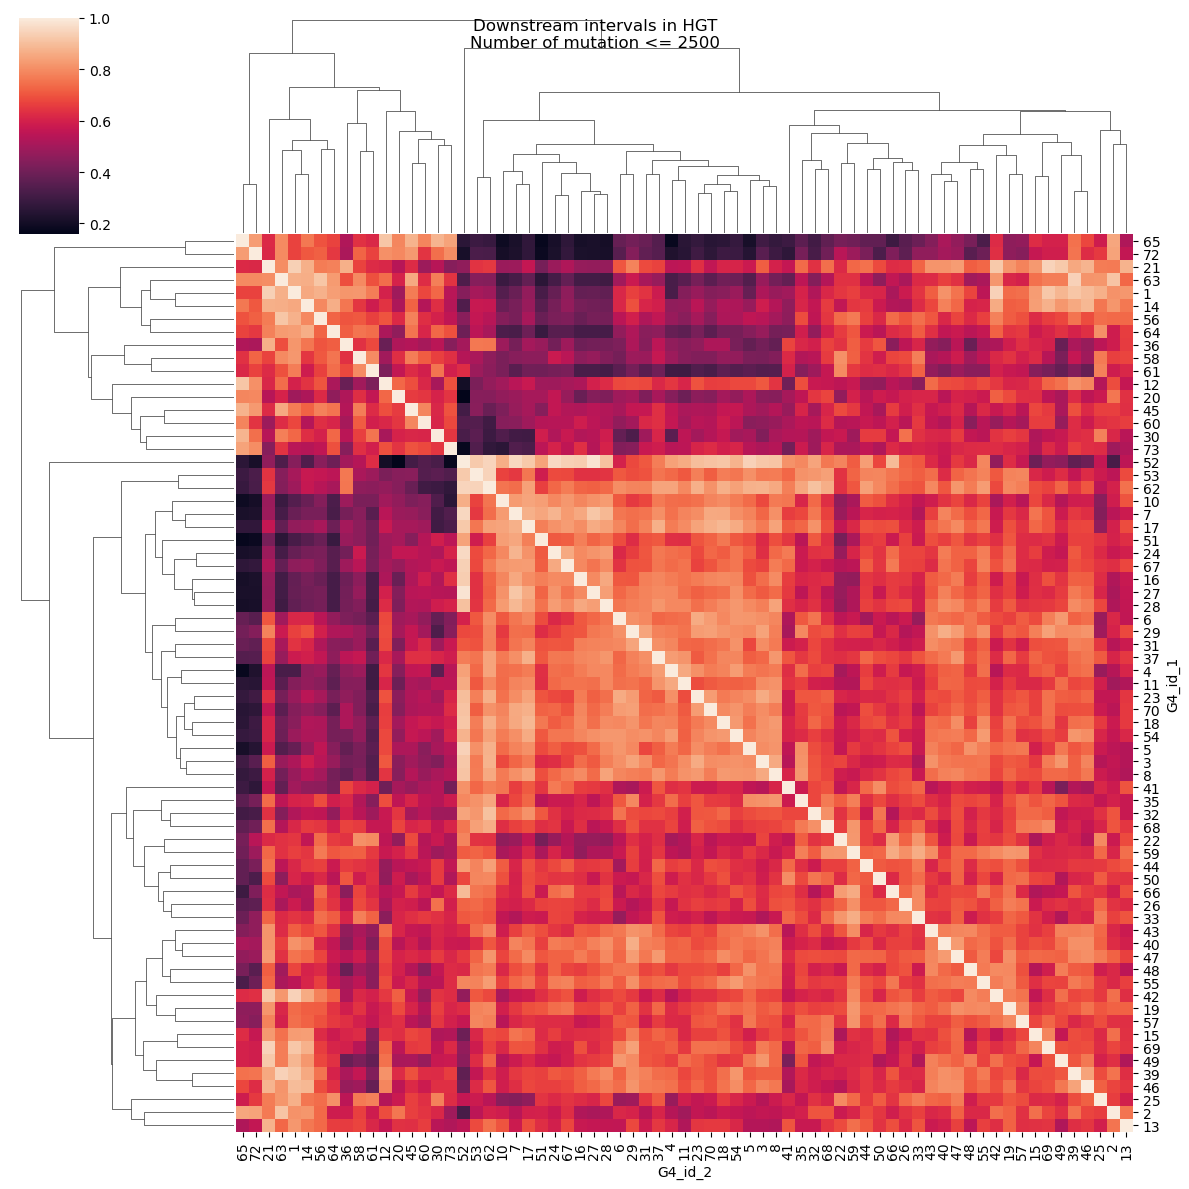

In [30]:
plot_intersecton(get_intersection_df
                 (df_win_hgt[(df_win_hgt['number_of_Mut'] <= 2500) & (df_win_hgt['number_of_Mut'] > 100)], 
                  up_side=False, i_col='number_of_Mut'),
                title='Downstream intervals in HGT\nNumber of mutation <= 2500')

In [31]:
df_win_hgt['Ts/Tv'] = df_win_hgt[['A>G', 'G>A', 'T>C', 'C>T']].sum(axis=1) \
    .div(df_win_hgt[['A>T', 'A>C', 'G>T', 'G>C', 'T>A', 'T>G', 'C>A', 'C>G']].sum(axis=1)) \
    .replace(np.inf, 16000) \
    .fillna(0)

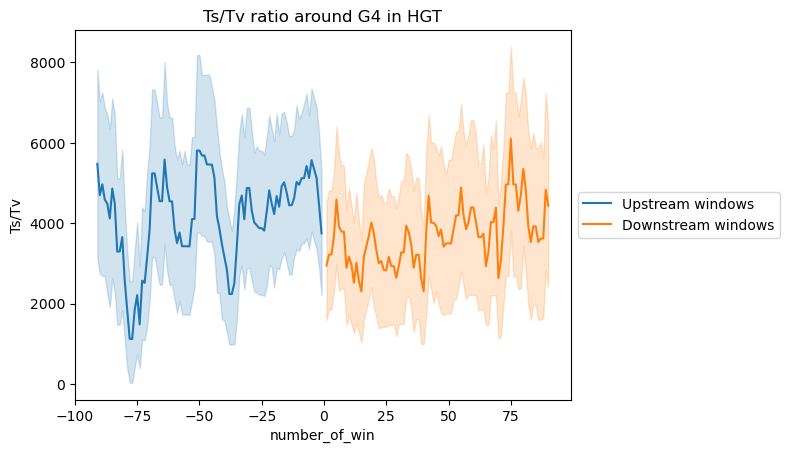

In [32]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_hgt[df_win_hgt['side']=='up'], 
             x=-df_win_hgt['number_of_win'], y='Ts/Tv', label='Upstream windows')
sns.lineplot(data=df_win_hgt[(df_win_hgt['side']=='down') & (df_win_hgt['Ts/Tv'] > 0)], 
             x='number_of_win', y='Ts/Tv', label='Downstream windows')
axs.set(title='Ts/Tv ratio around G4 in HGT')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

C:\Users\777\AppData\Local\Temp\ipykernel_11356\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)


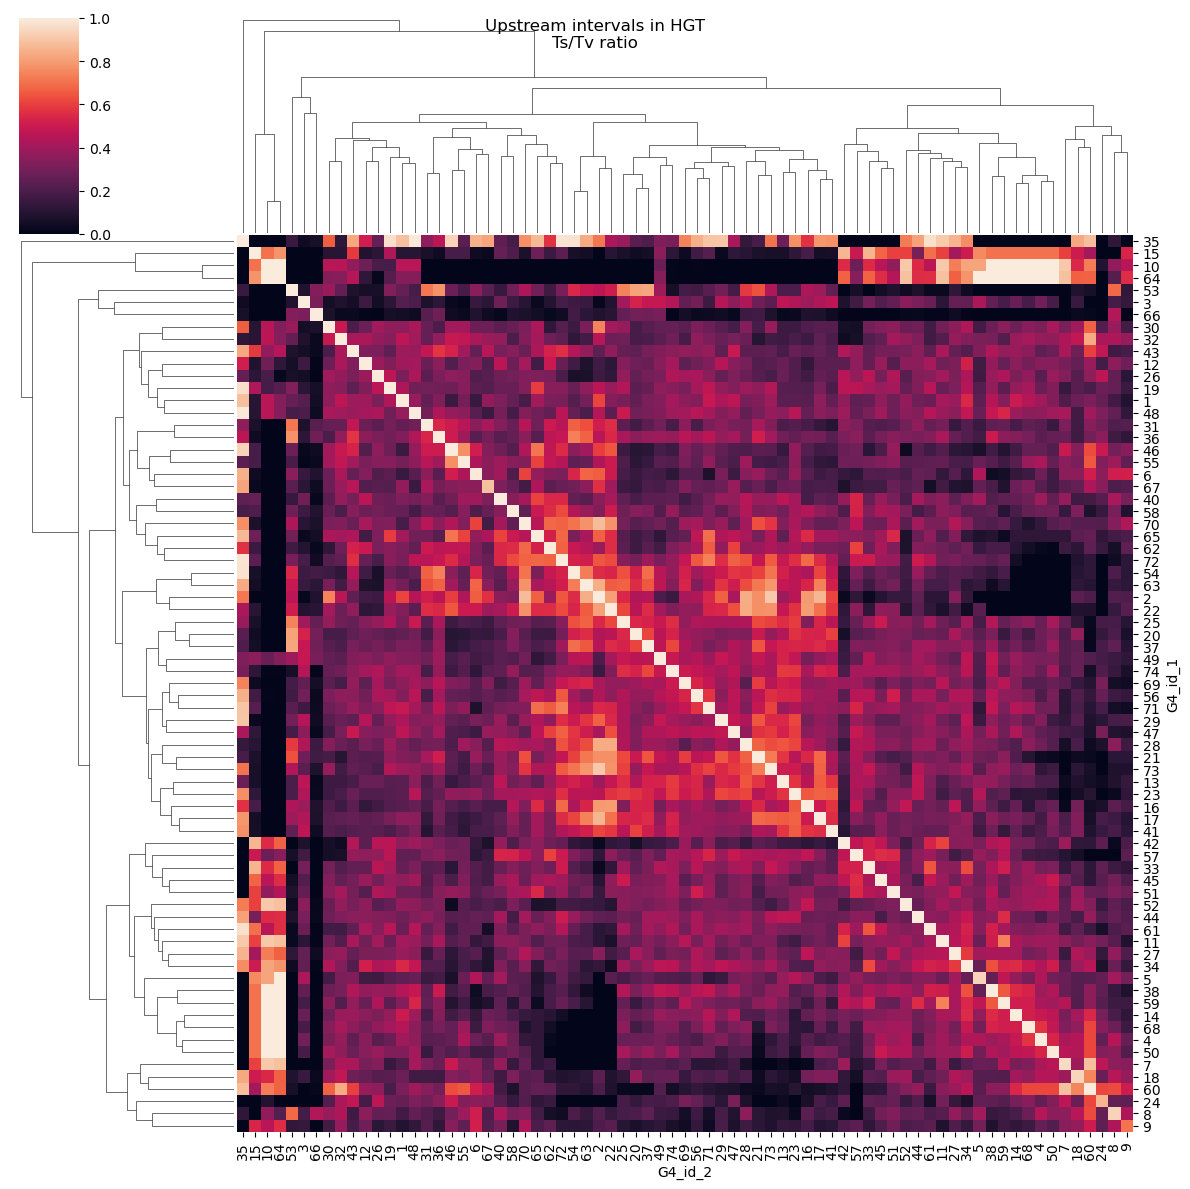

In [33]:
plot_intersecton(get_intersection_df(df_win_hgt, up_side=True, i_col='Ts/Tv'),
                title='Upstream intervals in HGT\nTs/Tv ratio')

C:\Users\777\AppData\Local\Temp\ipykernel_11356\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)


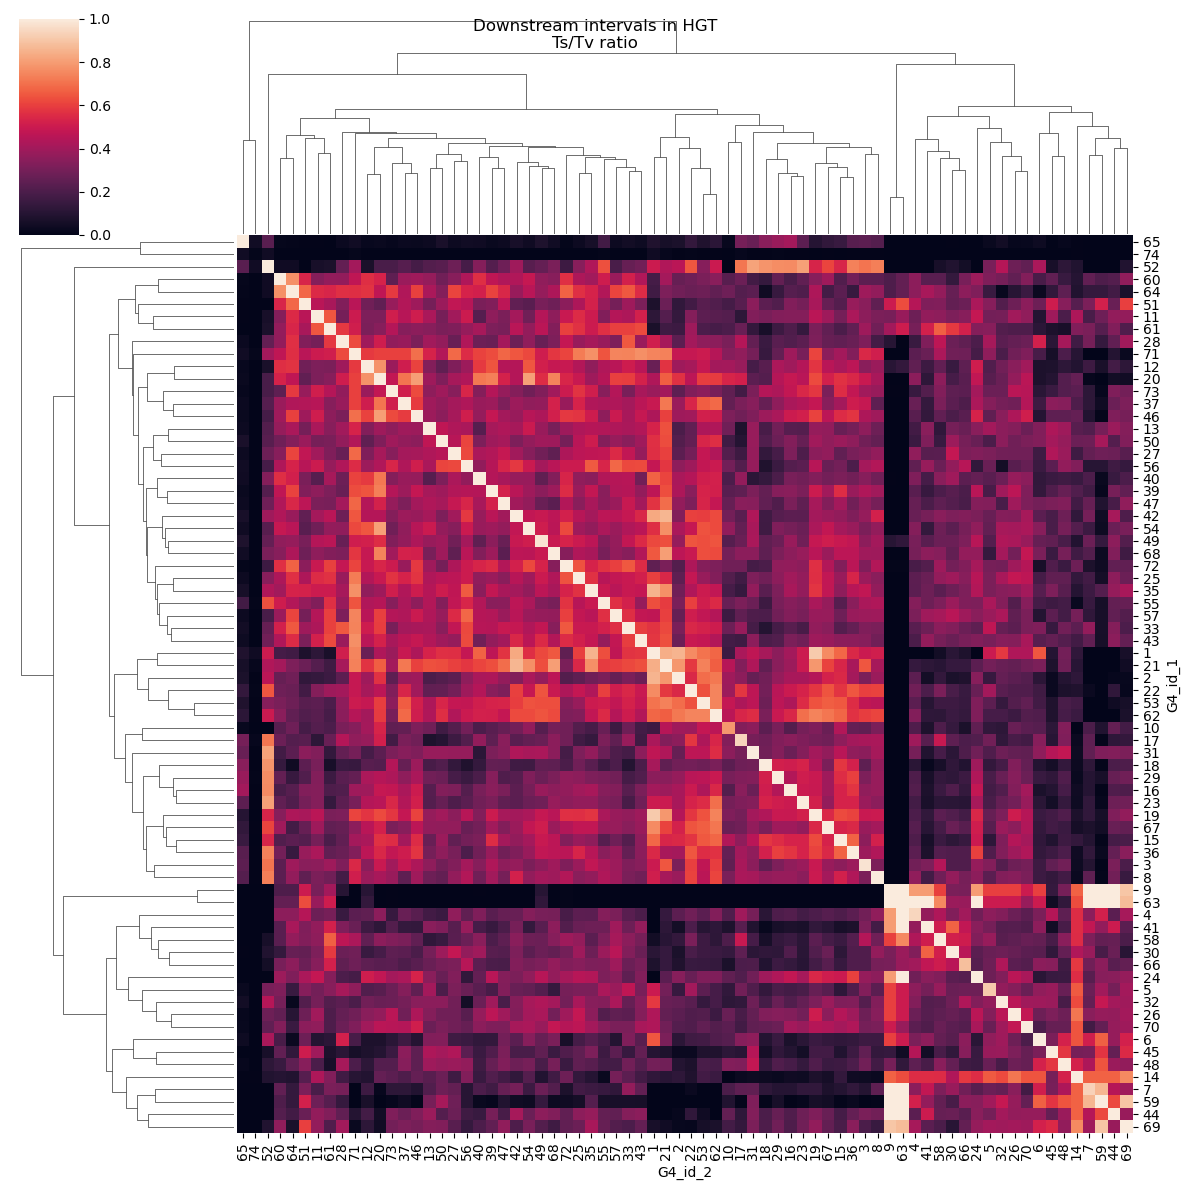

In [34]:
plot_intersecton(get_intersection_df(df_win_hgt, up_side=False, i_col='Ts/Tv'),
                title='Downstream intervals in HGT\nTs/Tv ratio')

In [35]:
og_u_tstv_hgt = [10, 64, 53, 66]
og_d_tstv_hgt = [65, 74]

In [36]:
df_win_hgt[(df_win_hgt['side'] == 'up') & (df_win_hgt['G4_id'].isin(og_u_tstv_hgt))]['Ts/Tv'].median()

16000.0

In [37]:
df_win_hgt[(df_win_hgt['side'] == 'down') & (df_win_hgt['G4_id'].isin(og_d_tstv_hgt))]['Ts/Tv'].median()

0.0

In [38]:
normMutG4_hgt = get_norm_mutspec(df_win_hgt)

In [39]:
normMutG4_hgt.insert(0, 'G4_id', df_win_hgt['G4_id'])
normMutG4_hgt.insert(1, 'side', df_win_hgt['side'])
normMutG4_hgt.insert(2, 'number_of_win', df_win_hgt['number_of_win'])
normMutG4_hgt = normMutG4_hgt.fillna(0)

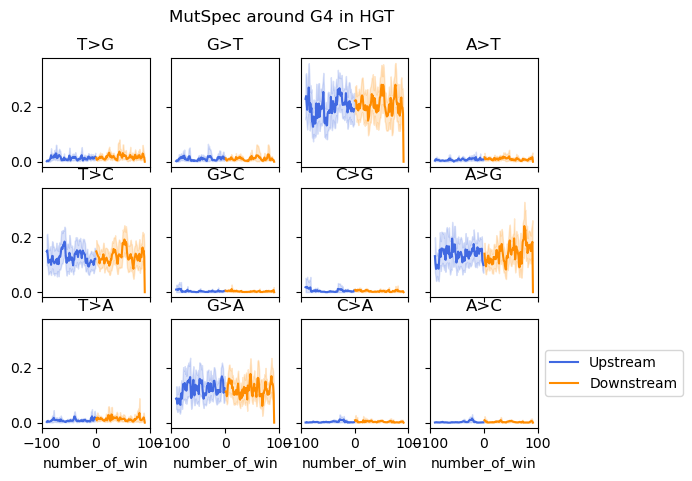

In [40]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True)
mutations = ['T>G', 'T>C', 'T>A', 'G>T', 'G>C', 'G>A', 'C>T', 'C>G', 'C>A', 'A>T', 'A>G', 'A>C']

colors = ['royalblue', 'darkorange']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 3
    row = i % 3
    sns.lineplot(data=normMutG4_hgt[normMutG4_hgt['side']=='up'], 
                 x=-normMutG4_hgt['number_of_win'], y=mutation, ax=axs[row, col], color=colors[0])
    sns.lineplot(data=normMutG4_hgt[normMutG4_hgt['side']=='down'], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[1]) \
        .set(title=mutation, ylabel='')
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Downstream']

# Add legend with custom handles and labels
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('MutSpec around G4 in HGT')
plt.show()

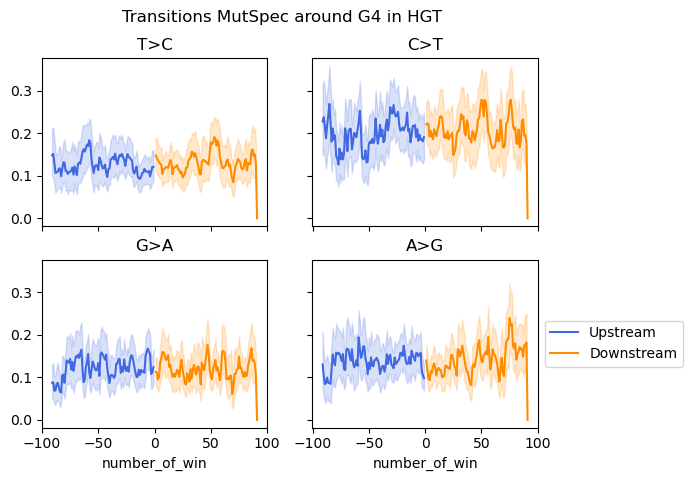

In [41]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 2
    row = i % 2
    sns.lineplot(data=normMutG4_hgt[normMutG4_hgt['side']=='up'], 
                 x=-normMutG4_hgt['number_of_win'], y=mutation, ax=axs[row, col], color=colors[0])
    sns.lineplot(data=normMutG4_hgt[normMutG4_hgt['side']=='down'], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[1]) \
        .set(title=mutation, ylabel='')
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Downstream']

# Add legend with custom handles and labels
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Transitions MutSpec around G4 in HGT')
plt.show()

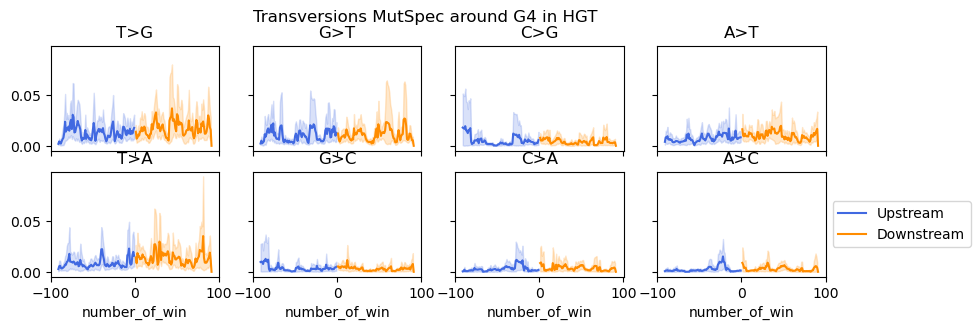

In [42]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True,  figsize=[10, 3])
mutations = ['T>G', 'T>A', 'G>T', 'G>C', 'C>G', 'C>A', 'A>T', 'A>C']

colors = ['royalblue', 'darkorange']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 2
    row = i % 2
    sns.lineplot(data=normMutG4_hgt[normMutG4_hgt['side']=='up'], 
                 x=-normMutG4_hgt['number_of_win'], y=mutation, ax=axs[row, col], color=colors[0])
    sns.lineplot(data=normMutG4_hgt[normMutG4_hgt['side']=='down'], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[1]) \
        .set(title=mutation, ylabel='')
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Downstream']

# Add legend with custom handles and labels
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Transversions MutSpec around G4 in HGT', y=1)
plt.show()

# Analisys around Strongest G4 in HGT

In [44]:
g4conf = pd.read_csv('../data/processed/g4conf.csv')

In [45]:
df_win_hgt_strong = df_win_hgt[df_win_hgt['G4_id'].isin(g4conf[g4conf['G4'] == 'G4']['G4_id'])]

In [46]:
normMutG4_hgt_strong = get_norm_mutspec(df_win_hgt_strong)

In [47]:
normMutG4_hgt_strong.insert(0, 'G4_id', df_win_hgt_strong['G4_id'])
normMutG4_hgt_strong.insert(1, 'side', df_win_hgt_strong['side'])
normMutG4_hgt_strong.insert(2, 'number_of_win', df_win_hgt_strong['number_of_win'])
normMutG4_hgt_strong = normMutG4_hgt_strong.fillna(0)

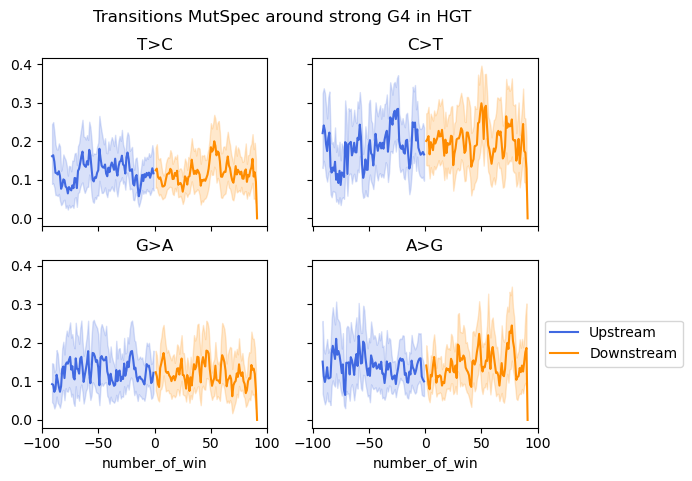

In [48]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 2
    row = i % 2
    sns.lineplot(data=normMutG4_hgt_strong[normMutG4_hgt_strong['side']=='up'], 
                 x=-normMutG4_hgt_strong['number_of_win'], y=mutation, ax=axs[row, col], color=colors[0])
    sns.lineplot(data=normMutG4_hgt_strong[normMutG4_hgt_strong['side']=='down'], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[1]) \
        .set(title=mutation, ylabel='')
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Downstream']

# Add legend with custom handles and labels
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Transitions MutSpec around strong G4 in HGT')
plt.show()

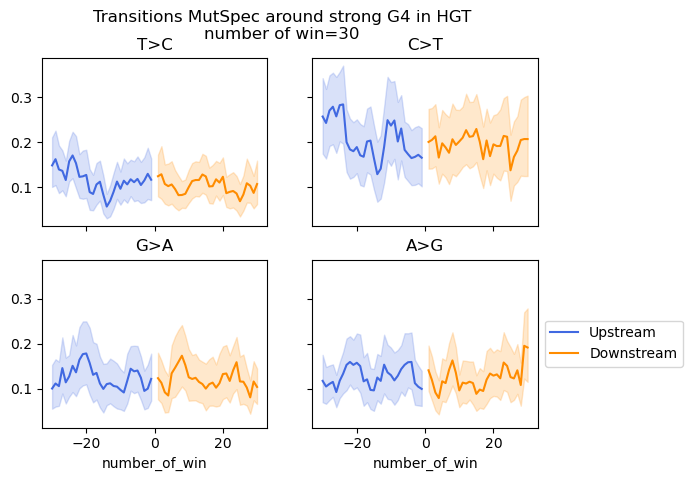

In [49]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
mutations = ['T>C', 'G>A', 'C>T', 'A>G']
number_of_win = range(31)

colors = ['royalblue', 'darkorange']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 2
    row = i % 2
    sns.lineplot(data=normMutG4_hgt_strong[(normMutG4_hgt_strong['side']=='up') & 
                 (normMutG4_hgt_strong['number_of_win'].isin(number_of_win))], 
                 x=-normMutG4_hgt_strong['number_of_win'], y=mutation, ax=axs[row, col], color=colors[0])
    sns.lineplot(data=normMutG4_hgt_strong[(normMutG4_hgt_strong['side']=='down') &
                 (normMutG4_hgt_strong['number_of_win'].isin(number_of_win))], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[1]) \
        .set(title=mutation, ylabel='')
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Downstream']

# Add legend with custom handles and labels
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Transitions MutSpec around strong G4 in HGT\nnumber of win=30')
plt.show()

# Within G4

In [50]:
df_win_hgt_within = pd.read_csv('../data/processed/df_win_hgt_within.csv')

In [51]:
df_win_hgt_within

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,within,1,285,294,CAAAAAATTT,6.0,1.0,0.0,3.0,...,0.0,0.0,76.0,5.0,0.0,0.0,8.0,88.0,0.0,189.0
1,1,within,2,286,295,AAAAAATTTC,6.0,1.0,0.0,3.0,...,26.0,0.0,128.0,5.0,0.0,0.0,9.0,140.0,0.0,346.0
2,1,within,3,287,296,AAAAATTTCC,5.0,2.0,0.0,3.0,...,28.0,0.0,152.0,5.0,0.0,0.0,9.0,163.0,0.0,397.0
3,1,within,4,288,297,AAAATTTCCA,5.0,2.0,0.0,3.0,...,34.0,0.0,152.0,72.0,0.0,0.0,9.0,163.0,0.0,548.0
4,1,within,5,289,298,AAATTTCCAC,4.0,3.0,0.0,3.0,...,35.0,0.0,152.0,67.0,0.0,0.0,9.0,163.0,0.0,539.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,74,within,19,16545,16554,TCCCCTTAAA,3.0,4.0,0.0,3.0,...,0.0,0.0,10.0,0.0,0.0,0.0,2.0,11.0,0.0,25.0
2738,74,within,20,16546,16555,CCCCTTAAAT,3.0,4.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,14.0
2739,74,within,21,16547,16556,CCCTTAAATA,4.0,3.0,0.0,3.0,...,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2.0,2.0,18.0
2740,74,within,22,16548,16557,CCTTAAATAA,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,4.0,0.0,2.0,4.0,2.0,2.0,22.0


[Text(0.5, 1.0, 'Number of mutation within G4 in HGT')]

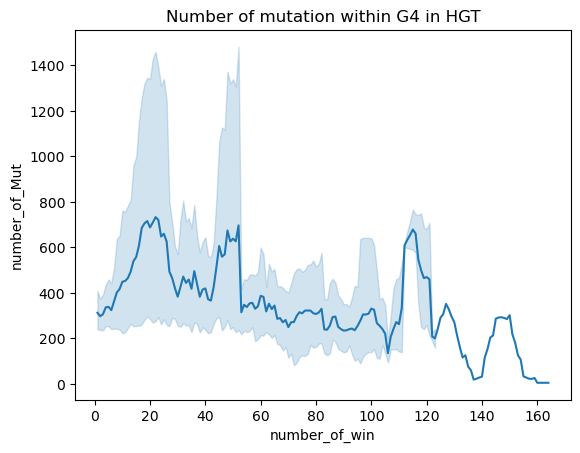

In [52]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_hgt_within,
             x='number_of_win', y='number_of_Mut')

axs.set(title='Number of mutation within G4 in HGT')
# axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

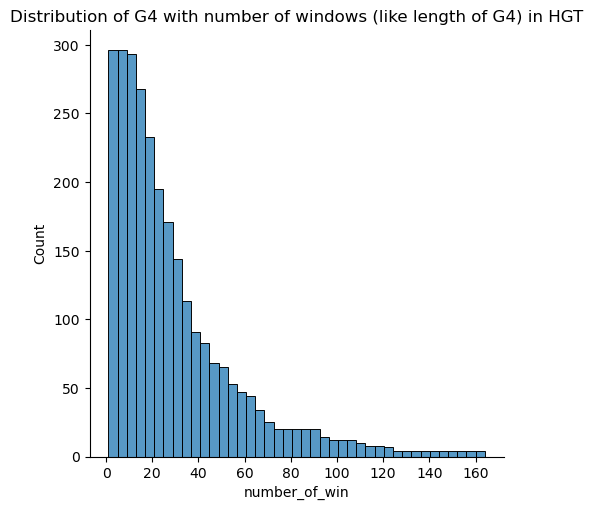

In [54]:
sns.displot(df_win_hgt_within['number_of_win']).set(title='Distribution of G4 with number of windows (like length of G4) in HGT')

[Text(0.5, 1.0, 'Number of mutation within G4 in HGT')]

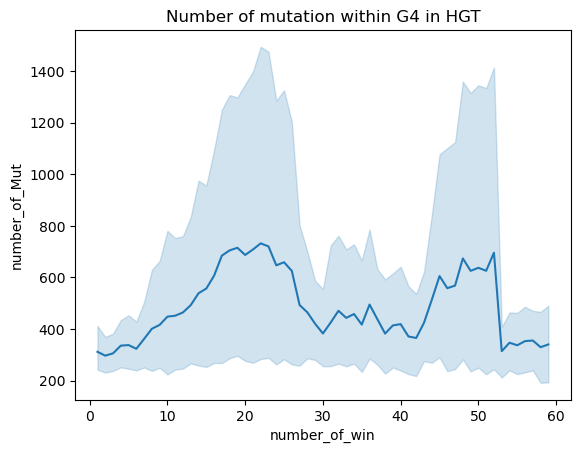

In [55]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_hgt_within[df_win_hgt_within['number_of_win'] < 60],
             x=df_win_hgt_within['number_of_win'], y='number_of_Mut')

axs.set(title='Number of mutation within G4 in HGT')
# axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [56]:
normMutG4_hgt_within = get_norm_mutspec(df_win_hgt_within)

In [57]:
normMutG4_hgt_within.insert(0, 'G4_id', df_win_hgt_within['G4_id'])
normMutG4_hgt_within.insert(1, 'side', df_win_hgt_within['side'])
normMutG4_hgt_within.insert(2, 'number_of_win', df_win_hgt_within['number_of_win'])
normMutG4_hgt_within = normMutG4_hgt_within.fillna(0)

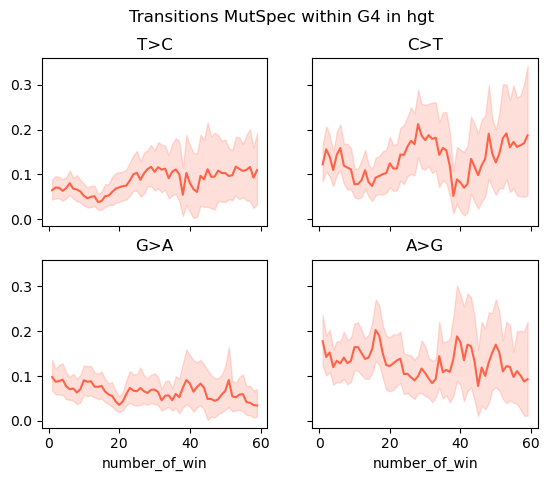

In [59]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 2
    row = i % 2
    sns.lineplot(data=normMutG4_hgt_within[normMutG4_hgt_within['number_of_win'] < 60], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[2])\
                .set(title=mutation, ylabel='')
        
# # Create custom legend handles and labels
# handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
# labels = ['Upstream', 'Downstream']

# # Add legend with custom handles and labels
# plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Transitions MutSpec within G4 in hgt')
plt.show()

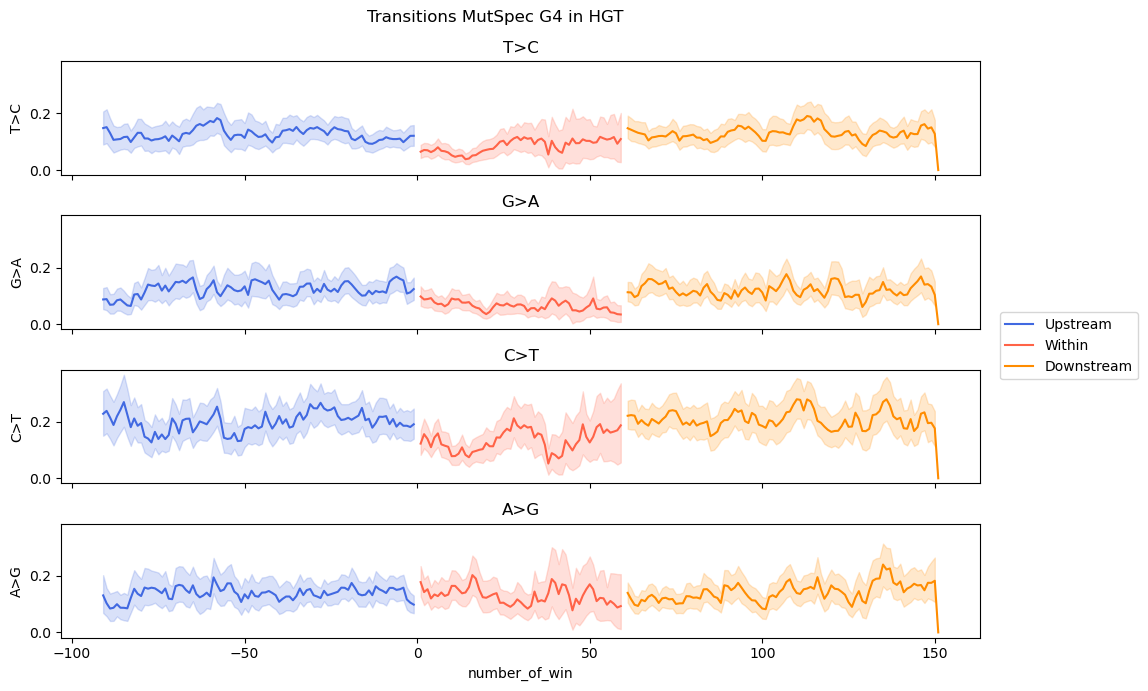

In [60]:
fig, axs = plt.subplots(4, sharex=True, sharey=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.lineplot(data=normMutG4_hgt[normMutG4_hgt['side']=='up'], 
                 x=-normMutG4_hgt['number_of_win'], y=mutation, ax=axs[row], color=colors[0])
    sns.lineplot(data=normMutG4_hgt_within[normMutG4_hgt_within['number_of_win'] < 60], 
                 x='number_of_win', y=mutation, ax=axs[row], color=colors[2])
    sns.lineplot(data=normMutG4_hgt[normMutG4_hgt['side']=='down'], 
                 x=normMutG4_hgt['number_of_win']+60, y=mutation, ax=axs[row], color=colors[1]) \
                .set_title(mutation)
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[2]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Within' ,'Downstream']

# Add legend with custom handles and labels
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5))
plt.suptitle('Transitions MutSpec G4 in HGT')
plt.tight_layout()
plt.show()